In [48]:
import numpy

from finance_utils.namedtuples import *
from finance_utils.uniontypes import *
from finance_utils.asset.spot.base import Spot,ServiceChargesSpot
# from finance_utils.asset.spot.strategy import SpotCostAveragingPlan
from finance_utils.strategy.dca import simple_dca, price_qualified_dca

from finance_utils.process.prices.gbm import RVDecoupledGBM, GBM, NormalDistribution
from finance_utils.trader.base import Trader
from finance_utils.trader.utility import *

from matplotlib import pyplot

from data_utils.stochastic_utils.distributions.nonParametricDistribution import HistogramDist, KernelMixDist, SmoothHisDist
from data_utils.stochastic_utils.random_process.correlatedRandom import random_correlated_series
from easy_datetime.timestamp import TimeStamp
import tqdm

from matplotlib import pyplot

In [157]:
class Test:
    def __init__(
            self, 
            cap=20000 * 12, 
            rr=(0.03, 0.03), 
            v=(0.015,0.015), 
            corr=(0,0), 
            weekdays=22,
            months=12,
            fee = 5e-4,
            tax = 5e-5
    ):
        self.cap = cap
        self.rr = rr
        self.v = v
        self.corr = corr
        self.weekdays = weekdays
        self.months = months
        self.stock1 = ServiceChargesSpot("stock1", 1, TradeDelta("day", 1), fee, tax)
        self.stock2 = ServiceChargesSpot("stock2", 1, TradeDelta("day", 1), fee, tax)
        
    def run(self, pr=0.99, sr=1.01, interval = (1,1)):
        sy = []
        sy2 = []
        ty = []
        ty2 = []
        trader1 = Trader("trader1", self.cap)
        trader2 = Trader("trader2", self.cap)
        days = self.weekdays * self.months
        r = random_correlated_series(
            [NormalDistribution(self.rr[0] / days, self.v[0]), NormalDistribution(self.rr[1] / days, self.v[1])],
            self.corr,
            days,
        )
        process1 = RVDecoupledGBM(self.stock1.name, r[0], 1, TimeStamp.now().accurate_to("year"), "day", 1)
        process2 = RVDecoupledGBM(self.stock2.name, r[1], 1, TimeStamp.now().accurate_to("year"), "day", 1)
        trigger_set = set(range(0, days, interval[0]))
        trigger_set2 = set(range(0, days, interval[1]))
        
        cap = self.cap / 2 / len(trigger_set)
        
        
        for i, t, path in process1.process_iter():
            cap2 = trader2.capital / 2
            path2 = process2[i]
            dic = {**path.dic, **path2.dic}
            _, spot_yield = simple_dca(process1.s0, i, t, path, self.stock1, trader1, cap, trigger_set)
            _, spot2_yield = simple_dca(process2.s0, i, t, path2, self.stock2, trader1, cap, trigger_set)
            _, _ = price_qualified_dca(process1.s0, i, t, path, self.stock1, trader2, cap2, trigger_set2, pr, sr)
            _, _ = price_qualified_dca(process2.s0, i, t, path2, self.stock2, trader2, cap2, trigger_set2, pr, sr)
            sy.append(spot_yield)
            sy2.append(spot2_yield)
            ty.append(trader1.net_worth_rate(**dic))
            ty2.append(trader2.net_worth_rate(**dic))
        return (numpy.array(l) for l in [sy,sy2,ty,ty2])
    
    def loop(self, pr=0.99, sr=1.01, interval = (1,1), epoch=100):
        for i in tqdm.trange(epoch):
            if i == 0:
                sy,sy2,ty,ty2 = self.run(pr, sr, interval)
            else:
                sy_t,sy2_t,ty_t,ty2_t = self.run()
                sy = numpy.column_stack((sy, sy_t))
                sy2 = numpy.column_stack((sy2, sy2_t))
                ty = numpy.column_stack((ty, ty_t))
                ty2 = numpy.column_stack((ty2, ty2_t))
        return sy,sy2,ty,ty2
            
        

100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


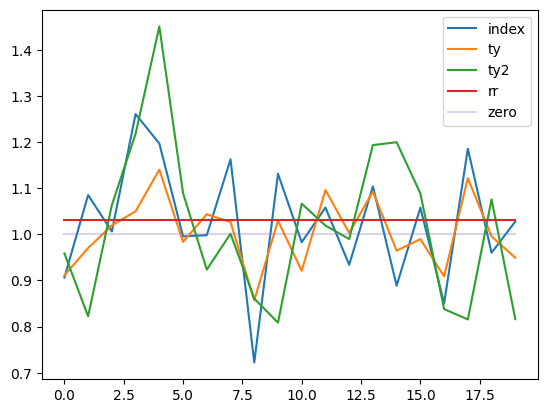

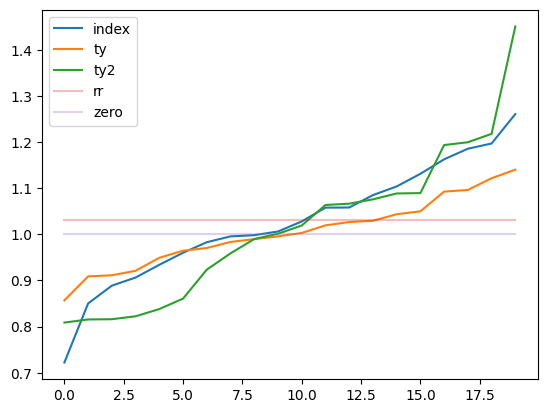

In [163]:
test = Test(
    20000,
    (0.03,0.03),
    (0.015,0.015),
    (0, 0),
    22,
    12,
    5e-4,
    5e-5
)

epoch = 20
sy,sy2,ty,ty2 = test.loop(0.99,1.01,(1,1), epoch)
# pyplot.plot(sy[-1], label="sy")
# pyplot.plot(sy2[-1], label="sy2")
pyplot.plot((sy[-1] + sy2[-1]) / 2, label="index")
pyplot.plot(ty[-1], label="ty")
pyplot.plot(ty2[-1], label="ty2")
pyplot.plot([1.03] * epoch, label="rr")
pyplot.plot([1.00] * epoch, label="zero", alpha=0.3)
pyplot.legend()
pyplot.show()

pyplot.plot(numpy.sort((sy[-1] + sy2[-1]) / 2), label="index")
pyplot.plot(numpy.sort(ty[-1]), label="ty")
pyplot.plot(numpy.sort(ty2[-1]), label="ty2")
pyplot.plot([1.03] * epoch, label="rr", alpha=0.3)
pyplot.plot([1.00] * epoch, label="zero", alpha=0.3)
pyplot.legend()
pyplot.show()

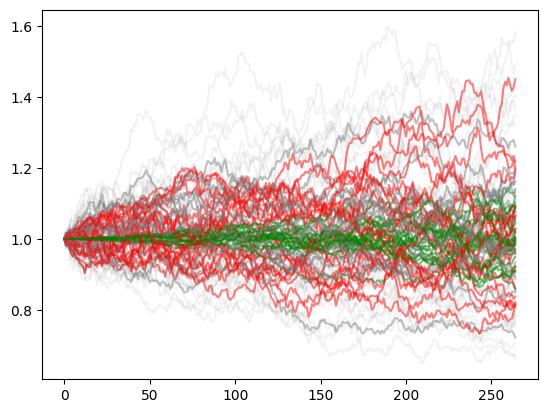

In [164]:
for i in range(epoch):
    pyplot.plot(sy[:,i], label="sy", color="gray", alpha=0.1)
    pyplot.plot(sy2[:,i], label="sy2", color="gray", alpha=0.1)
    pyplot.plot((sy[:,i] + sy2[:,i]) /2, label="index", color="gray", alpha=0.5)
    pyplot.plot(ty[:,i], label="ty", color="green", alpha=0.5)
    pyplot.plot(ty2[:,i], label="ty2", color="red", alpha=0.5)
    # pyplot.legend()
pyplot.show()

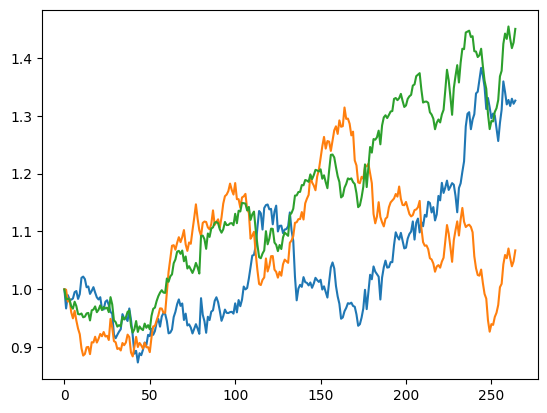

In [165]:
i = numpy.argsort(ty2[-1])[-1]
pyplot.plot(sy[:,i])
pyplot.plot(sy2[:,i])
# pyplot.plot(ty[:,i])
pyplot.plot(ty2[:,i])
pyplot.show()